In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import os
import time

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [4]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'length of text: {len(text)} characters')

length of text: 1115394 characters


In [7]:
print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [8]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [12]:
example_texts = ['asdfasdg', 'daf']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b's', b'd', b'f', b'a', b's', b'd', b'g'], [b'd', b'a', b'f']]>

In [15]:
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab), mask_token=None
)

In [18]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 58, 43, 45, 40, 58, 43, 46], [43, 40, 45]]>

In [19]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None
)

In [20]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b's', b'd', b'f', b'a', b's', b'd', b'g'], [b'd', b'a', b'f']]>

In [21]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'asdfasdg', b'daf'], dtype=object)

In [22]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [24]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [25]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [26]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [27]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [30]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [32]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [33]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [34]:
split_input_target(list('Tensorflow'))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [35]:
dataset = sequences.map(split_input_target)

In [36]:
for input_example, target_example in dataset.take(1):
  print('Input :', text_from_ids(input_example).numpy())
  print('Target :', text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target : b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [38]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset.shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [39]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [47]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [48]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

In [49]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape)

(64, 100, 66)


In [50]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  16896     
_________________________________________________________________
gru_2 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_2 (Dense)              multiple                  67650     
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [51]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=1).numpy()

In [52]:
sampled_indices

array([40, 26, 43, 13, 50, 61, 40, 60, 59,  2,  6, 51, 25, 16, 46, 40, 63,
       62, 36, 26, 60, 40, 33, 29,  2, 57, 38, 23, 44, 50, 14,  7, 15, 64,
       42,  3, 62, 25, 41, 27, 32, 56, 15, 52, 51, 39,  9, 54, 55, 59, 28,
       19, 17, 65, 47, 37, 45, 65,  9, 13, 42, 34,  2, 30, 38, 53, 18, 29,
       23, 24, 15, 60, 12,  4, 54, 61, 19,  0, 30,  1, 26, 49, 12, 56, 11,
       30, 43, 58, 59, 18, 21, 60, 47, 64,  1, 17, 63, 29,  4, 31])

In [53]:
print('Input:\n ', text_from_ids(input_example_batch[0]).numpy())
print()
print('Next char predictions:\n ', text_from_ids(sampled_indices).numpy())

Input:
  b'ok on death no more!\n\nQUEEN ELIZABETH:\nCome, come, my boy; we will to sanctuary.\nMadam, farewell.\n\nD'

Next char predictions:
  b"aMd?kvaut 'lLCgaxwWMuaTP rYJekA,Byc!wLbNSqBmlZ.optOFDzhXfz.?cU QYnEPJKBu;$ovF[UNK]Q\nMj;q:QdstEHuhy\nDxP$R"


In [54]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [56]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print('Prediction shape: ', example_batch_predictions.shape)
print('Mean loss: ', mean_loss)

Prediction shape:  (64, 100, 66)
Mean loss:  4.189501


In [57]:
tf.exp(mean_loss).numpy()

65.98984

In [58]:
model.compile(optimizer='adam', loss=loss)

In [62]:
checkpoints_dir = './training_checkpoints'
checkpoints_prefix = os.path.join(checkpoints_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_prefix,
    save_weights_only=True
)

In [63]:
EPOCHS = 20

In [65]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 881s 5s/step - loss: 2.7240
Epoch 2/20
172/172 [==============================] - 880s 5s/step - loss: 1.9928
Epoch 3/20
172/172 [==============================] - 871s 5s/step - loss: 1.7159
Epoch 4/20
172/172 [==============================] - 877s 5s/step - loss: 1.5545
Epoch 5/20
172/172 [==============================] - 875s 5s/step - loss: 1.4534
Epoch 6/20
172/172 [==============================] - 883s 5s/step - loss: 1.3849
Epoch 7/20
172/172 [==============================] - 890s 5s/step - loss: 1.3316
Epoch 8/20
172/172 [==============================] - 878s 5s/step - loss: 1.2882
Epoch 9/20
172/172 [==============================] - 873s 5s/step - loss: 1.2461
Epoch 10/20
172/172 [==============================] - 882s 5s/step - loss: 1.2065
Epoch 11/20
172/172 [==============================] - 883s 5s/step - loss: 1.1671
Epoch 12/20
172/172 [==============================] - 884s 5s/step - loss: 1.1265
Epoch 13/20
1

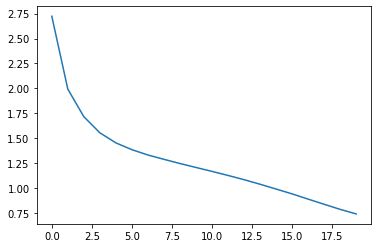

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])